# Individual Assigment 2:

## Public Media: Recommender Systems and User`s Interface

March/2021 

Hans Alberto Franke - 6987680

In [ ]:
#load datasets: Small version!
import pandas as pd

movies_df = pd.read_csv('ml-small/movies.csv')
ratings_df = pd.read_csv('ml-small/ratings.csv')
links_df = pd.read_csv('ml-small/links.csv')
tags_df = pd.read_csv('ml-small/tags.csv')

In [2]:
#merge dataframes
#drop timestamp from tags_df (avoid double timestamps / user_id)
tags_df.drop(columns='timestamp', inplace=True)
tags_df.drop(columns='userId', inplace=True)
#merging all dataframes
full_df = movies_df.merge(ratings_df, left_on='movieId', right_on='movieId')
#full_df = full_df.merge(links_df, left_on='movieId', right_on='movieId') #will not use link to Imdb
full_df = full_df.merge(tags_df, left_on='movieId', right_on='movieId')
full_df.shape

(233213, 7)

In [3]:
full_df.head()

,movieId,title,genres,userId,rating,timestamp,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,pixar
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,pixar
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,fun
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,pixar
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,pixar


In [4]:
#Look for datatypes and look for missing values, seems no missing value!
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233213 entries, 0 to 233212
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    233213 non-null  int64  
 1   title      233213 non-null  object 
 2   genres     233213 non-null  object 
 3   userId     233213 non-null  int64  
 4   rating     233213 non-null  float64
 5   timestamp  233213 non-null  int64  
 6   tag        233213 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 14.2+ MB


In [5]:
#Transform genres to rows
full_df_genres = full_df.copy()
full_df_genres['genres'] = full_df_genres['genres'].str.split('|').tolist()
full_df_genres = full_df_genres.explode("genres")
full_df_genres

,movieId,title,genres,userId,rating,timestamp,tag
0,1,Toy Story (1995),Adventure,1,4.0,964982703,pixar
0,1,Toy Story (1995),Animation,1,4.0,964982703,pixar
0,1,Toy Story (1995),Children,1,4.0,964982703,pixar
0,1,Toy Story (1995),Comedy,1,4.0,964982703,pixar
0,1,Toy Story (1995),Fantasy,1,4.0,964982703,pixar
...,...,...,...,...,...,...,...
233211,193565,Gintama: The Movie (2010),Sci-Fi,184,3.5,1537098554,gintama
233212,193565,Gintama: The Movie (2010),Action,184,3.5,1537098554,remaster
233212,193565,Gintama: The Movie (2010),Animation,184,3.5,1537098554,remaster
233212,193565,Gintama: The Movie (2010),Comedy,184,3.5,1537098554,remaster


# Simpler Recommender
### Scored based on votes and ratings

In [6]:
#Define a base function to allow weigthed vote, so it changes ratings to score, based on number of votes and ratings!
#You can avg votes by movie or by genre, it would be used later on!
def weight_votes(df, group_col='title', agg_col ="rating", number=10):
    avg_rating_df = df.copy()
    # calculate average with count
    avg_rating_df = df.groupby([group_col])[agg_col].agg(['mean', 'count'])
    avg_rating_df.rename(columns={'mean': 'vote_average', 'count': 'vote_count'}, inplace=True)
    avg_rating_df.sort_values('vote_average', ascending=False).head(10)
        
    # C is the mean vote or rating across the whole dataframe
    C = avg_rating_df['vote_average'].mean()

    # m is the minimum votes or ratings to be listed | using a low value because the dataset is small
    m = avg_rating_df['vote_count'].quantile(0.50)
    print('Numbers of votes to be in final list:', m)
    
    # weight function (ranked based on number of votes AND score)
    def weighted_rating(x, m=m, C=C):
        v = x['vote_count']
        R = x['vote_average']
        return (v / (v + m) * R) + (m / (m + v) * C)

    # check the new scores
    avg_rating_df = avg_rating_df.loc[avg_rating_df['vote_count'] >= m]
    avg_rating_df['score'] = avg_rating_df.apply(weighted_rating, axis=1)
    avg_rating_df = avg_rating_df.sort_values('score', ascending=False).head(number)
    return avg_rating_df

avg_rating_df = weight_votes(full_df_genres, "genres")
avg_rating_df

Numbers of votes to be in final list: 14241.5


,vote_average,vote_count,score
genres,,,
Crime,4.123582,103102,4.101546
Thriller,4.074407,116891,4.060029
Drama,4.053360,148389,4.043609
Comedy,3.992477,96901,3.986011
Action,3.952206,69549,3.950475
Mystery,3.923477,24352,3.930318
Sci-Fi,3.901226,51977,3.909998
Adventure,3.881026,47939,3.894995
Romance,3.801708,25344,3.852187


In [7]:
avg_rating_df = weight_votes(full_df, "title")
avg_rating_df

Numbers of votes to be in final list: 19.0


,vote_average,vote_count,score
title,,,
"Shawshank Redemption, The (1994)",4.429022,1268,4.417556
Guess Who's Coming to Dinner (1967),4.545455,44,4.276109
Fight Club (1999),4.272936,11772,4.271936
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964),4.268041,970,4.256213
"Departed, The (2006)",4.252336,1070,4.241869
Rear Window (1954),4.261905,504,4.239761
"Godfather, The (1972)",4.289062,192,4.231729
"Godfather: Part II, The (1974)",4.259690,387,4.231268
Star Wars: Episode IV - A New Hope (1977),4.231076,6526,4.229396


### Trend Users

In [8]:
#Capture trend users: It is useful to look for trend users to suggest movies that are trending of heavy users!
def trend_users(df, col_name = "userId"):
    #list of top 10 users with most ratings => trending users!
    avg_rating_user = full_df.groupby(col_name)['rating'].agg(['mean', 'count'])
    avg_rating_user.rename(columns={'mean': 'vote_average', 'count': 'vote_count'}, inplace=True)
    #avg_rating_user.sort_values('vote_count', ascending=False).head(10)
    return  avg_rating_user.sort_values('vote_count', ascending=False).head(10)
trend_users(full_df)

,vote_average,vote_count
userId,,
474,3.778004,2455
414,4.134016,2343
599,3.480476,2100
68,3.183696,1791
610,4.310994,1701
274,3.811111,1665
249,4.188685,1635
448,3.636508,1575
380,4.250651,1536


# Content based Filtering

Content-based approaches attempt to build a user profile to predict ratings on unseen items.
Successful content-based methods utilize tags and keywords. Measuring the utility of content-based
filtering is commonly calculated by using heuristic functions, such as the cosine similarity metric.
Content-based filtering can be employed in many cases, where the features’ values can easily be
extracted. Content-based filtering is not typically used in cases where features values must be manually
entered. This can be manageable for small datasets, but when thousands of new products are being
added daily, this task is impossible. Content-based filtering does not require other users’ data, as the
predicted recommendations are user-specific. Thus, these techniques scale up the system to handle
many users. Content-based filtering is user-independent since this system only requires analyzing the
items and user profile for recommendations.

## Based on what you have watched...

### Pairwise Similarity

In [9]:
#pairwise similarities: Recommend a movie based on similaritie to another movie, the similaritie is the number of "ratings" of a user that watched a movie_a to movie_b

def recommend_similarMovies(df):
    from itertools import permutations
    # create a function that makes combinations of the movie that a user (x) reviewed
    def create_combinations(x):
        combinations = pd.DataFrame(list(permutations(x.values, 2)), columns=['item_a', 'item_b'])
        return combinations
    full_df = df.copy()
    # use the create_combinations function
    movie_combinations = full_df.groupby('userId')['title'].apply(create_combinations)
    movie_combinations = movie_combinations.reset_index(drop=True)
    combi_count = movie_combinations.groupby(['item_a', 'item_b']).size()
    combi_count = combi_count.to_frame(name='size').reset_index()

    #remove duplicates (same movie iteam_a and b)
    combi_count['equal'] = combi_count['item_a'] == combi_count["item_b"]
    combi_count = combi_count[combi_count['equal'] == False]
    combi_count.drop(columns='equal', inplace=True) #remove this ugly name!

    #sort by size!
    combi_count.sort_values('size', ascending=False)
    return combi_count

combi_count = recommend_similarMovies(full_df)

#Similarities based on a text search for example and a default parameter! The size is about how many users that rated movie_a rated movie_b
search_box = "Star Wars" #Can be a user search button, or the last watched movies for example!
minium_size = 30 #users who watched item_a, watched item_b

test_names = combi_count[( combi_count['item_a'].str.contains(search_box) ) & (combi_count['size'] > minium_size)]
test_names.sort_values(by='size', ascending=False)

,item_a,item_b,size
1643533,Star Wars: Episode IV - A New Hope (1977),Pulp Fiction (1994),724724
1645074,Star Wars: Episode V - The Empire Strikes Back...,Pulp Fiction (1994),251590
1642900,Star Wars: Episode IV - A New Hope (1977),Fight Club (1999),188136
1642474,Star Wars: Episode IV - A New Hope (1977),2001: A Space Odyssey (1968),90610
1643263,Star Wars: Episode IV - A New Hope (1977),Léon: The Professional (a.k.a. The Professiona...,77350
...,...,...,...
1584789,Solo: A Star Wars Story (2018),"Shawshank Redemption, The (1994)",32
1640940,Star Wars: Episode III - Revenge of the Sith (...,10 Cloverfield Lane (2016),32
1584651,Solo: A Star Wars Story (2018),Old Boy (2003),32
1640883,Star Wars: Episode I - The Phantom Menace (1999),When We Were Kings (1996),32


In [10]:
#test some recommendation based of ocurrance
#variable defined by user 
#film_name = input('Type the name of your movie:')
#to run 1st time without pausing
film_name = "Star Wars: Episode IV - A New Hope (1977)"

common_movies = combi_count[combi_count['item_a'] == film_name].sort_values("size", ascending=False).head(5)
common_movies = common_movies.reset_index(drop=True)

print("These are the 5 movies that users who watched {}, rated:".format(film_name))
#merge rating informations (Dataset create before and using list of name as a input)

#select avg_ratings | with full df returning (number parameter)
avg_rating_df = weight_votes(full_df, "title", number=9999999999999999999)

#remember scores = number of votes and rates!!
scores = avg_rating_df["score"].loc[common_movies['item_b']]
common_movies['score'] = scores.values
#common_movies.drop(columns='equal', inplace=True)
common_movies.sort_values("score", ascending=False).head(5)


These are the 5 movies that users who watched Star Wars: Episode IV - A New Hope (1977), rated:
Numbers of votes to be in final list: 19.0


,item_a,item_b,size,score
1,Star Wars: Episode IV - A New Hope (1977),Fight Club (1999),188136,4.271936
0,Star Wars: Episode IV - A New Hope (1977),Pulp Fiction (1994),724724,4.196882
4,Star Wars: Episode IV - A New Hope (1977),Eternal Sunshine of the Spotless Mind (2004),68068,4.158148
3,Star Wars: Episode IV - A New Hope (1977),Léon: The Professional (a.k.a. The Professiona...,77350,4.017307
2,Star Wars: Episode IV - A New Hope (1977),2001: A Space Odyssey (1968),90610,3.893470


## CrossTab Similarities

### Similar Movies x Users (Jaccard Similarity )

In [11]:
# let's make a crosstab (Movies x Users)
movies_category_users = pd.crosstab(full_df_genres['title'], full_df_genres['userId'])
movies_category_users

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer (2009),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,24
...And Justice for All (1979),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10 Cloverfield Lane (2016),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
10 Things I Hate About You (1999),0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,2,0,0,0,0,0
101 Dalmatians (1996),0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,6,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zero Dark Thirty (2012),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zombieland (2009),0,18,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,18
Zoolander (2001),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6,0,6


In [12]:
movies_category_users.shape

(1554, 610)

In [13]:
#Create a function to use Jaccard Similarity 
def get_dist_jaccard(df_crosstab):
    # import necessary stuff
    from sklearn.metrics import jaccard_score
    from scipy.spatial.distance import pdist, squareform

    
    # calculate the distances
    jaccard_distances = pdist(df_crosstab.values, metric='jaccard')
    square_jaccard_distances = squareform(jaccard_distances)
     
    jaccard_similarity_array = 1 - square_jaccard_distances
 
    distance_df_movies_category = pd.DataFrame(jaccard_similarity_array, index=df_crosstab.index, columns=df_crosstab.index)
    return distance_df_movies_category

#Create a function to return movies based on distance df created before and a movie name
def recommend_jaccard(dist_df, item_name, number=10):
    recomendations = dist_df[item_name].sort_values(ascending=False).head(number)[1:] #because the first element is the own movie
    return recomendations

#distance movies x users
distance_df_movies_users = get_dist_jaccard(movies_category_users)
distance_df_movies_users 

title,(500) Days of Summer (2009),...And Justice for All (1979),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),"11'09""01 - September 11 (2002)",12 Angry Men (1957),127 Hours (2010),13 Going on 30 (2004),...,Young Frankenstein (1974),Z (1969),Zack and Miri Make a Porno (2008),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zombieland (2009),Zoolander (2001),Zulu (1964),eXistenZ (1999)
title,,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer (2009),1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00,0.00
...And Justice for All (1979),0.0,1.000000,0.000000,0.017857,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.014085,0.000000,0.000000,0.333333,0.0,0.0,0.0,0.000000,0.00,0.00
10 Cloverfield Lane (2016),0.0,0.000000,1.000000,0.014925,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.024691,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00,0.00
10 Things I Hate About You (1999),0.0,0.017857,0.014925,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.138889,0.000000,0.000000,0.018519,0.0,0.0,0.0,0.000000,0.00,0.00
101 Dalmatians (1996),0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.079365,0.000000,0.0,0.0,0.0,0.147727,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zero Dark Thirty (2012),0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.00,0.00
Zombieland (2009),0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.00,0.00
Zoolander (2001),0.0,0.000000,0.000000,0.000000,0.147727,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.171875,0.000000,0.0,0.0,0.0,1.000000,0.00,0.00


In [14]:
#Recommend movies based on Movie title
movie_name = 'Zoolander (2001)'

#get recommendations based on users
recommend_jaccard(distance_df_movies_users, movie_name)


title
Kill Bill: Vol. 1 (2003)                               0.302817
Shrek 2 (2004)                                         0.292035
Mask of Zorro, The (1998)                              0.252747
X-Men: The Last Stand (2006)                           0.247059
Star Wars: Episode III - Revenge of the Sith (2005)    0.245283
Super Size Me (2004)                                   0.238095
Harry Potter and the Prisoner of Azkaban (2004)        0.235294
Lost in Translation (2003)                             0.230769
Space Jam (1996)                                       0.229885
Name: Zoolander (2001), dtype: float64

## Similar Movies x Tags (Cosine Similarity )

In [15]:
#select a subset of fields only
def get_tag_df(df):
    smaller_selection = df.groupby(['title', 'tag', "genres"]).size().reset_index(name='counts')
    smaller_selection = smaller_selection.reset_index(drop=True).drop_duplicates()
    
    #need to group tags in one row

    # concatenate the string
    smaller_selection['tag'] = smaller_selection.groupby(['title'])['tag'].transform(lambda x : ' '.join(x)) 

    # drop duplicate data
    #smaller_selection_tag.drop(columns=['index', 'counts'], inplace=True)
    smaller_selection = smaller_selection.drop_duplicates(subset=['title'])  
    smaller_selection.reset_index(drop=True,inplace=True)
    
    return smaller_selection

#define a function, it should receive a df with tags concatenated in a row!
def get_cos_recommendations(df_tag, film_name):
    # import TfidfVectorize
    from sklearn.feature_extraction.text import TfidfVectorizer
    tfidf = TfidfVectorizer(stop_words='english')
    df_tag['tag'] = df_tag['tag'].fillna('')
    tfidf_matrix = tfidf.fit_transform(df_tag['tag'])
   
    from sklearn.metrics.pairwise import linear_kernel
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

    indices = pd.Series(df_tag.index, index=df_tag['title']).drop_duplicates()
   

    def get_recommendations(film_name, cosine_sim=cosine_sim):
        # Get the index of the movie that matches the title
        idx = indices[film_name]

        # Get the pairwsie similarity scores of all movies with that movie
        sim_scores = list(enumerate(cosine_sim[idx]))

        # Sort the movies based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the scores of the 10 most similar movies
        sim_scores = sim_scores[1:11]

        # Get the movie indices
        movie_indices = [i[0] for i in sim_scores]

        # Return the top 10 most similar movies
        df_tag_2 = df_tag.iloc[movie_indices]
        
        #add the scores to the dataframe!
        df_tag_2['sim_scores'] = sim_scores
        return df_tag_2
    
    movies_list = get_recommendations(film_name)
    return movies_list

In [16]:
full_df.loc[full_df["title"] == film_name, "title"].values[0]

'Star Wars: Episode IV - A New Hope (1977)'

In [17]:
#Recommend 10 movies based on movie tag's of that film name
film_name = "101 Dalmatians (1996)"
tag_df = get_tag_df(full_df)
print("Your Movie is: {}, with genres: {}, and tags: {}".format(full_df.loc[full_df["title"] == film_name, "title"].values[0], 
                                                                full_df.loc[full_df["title"] == film_name, "genres"].values[0], 
                                                                tag_df.loc[ tag_df["title"] == film_name, "tag"].values[0] ) )

list_movies = get_cos_recommendations(tag_df,film_name)

list_movies


Your Movie is: 101 Dalmatians (1996), with genres: Adventure|Children|Comedy, and tags: dogs remake


<ipython-input-15-465f68dabd06>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tag_2['sim_scores'] = sim_scores


,title,tag,genres,counts,sim_scores
1432,Turner & Hooch (1989),dogs,Comedy|Crime,13,"(1432, 0.7454043699144903)"
581,"Haunting, The (1999)",remake,Horror|Thriller,13,"(581, 0.6666125751231985)"
1161,Sabrina (1995),remake,Comedy|Romance,54,"(1161, 0.6666125751231985)"
1452,"Vanishing, The (1993)",remake,Mystery|Thriller,4,"(1452, 0.6666125751231985)"
135,Best in Show (2000),Dogs satire,Comedy,53,"(135, 0.5590052628955666)"
430,Father of the Bride (1991),remake wedding,Comedy,13,"(430, 0.4502217750416548)"
431,Father of the Bride Part II (1995),pregnancy remake,Comedy,49,"(431, 0.4502217750416548)"
1231,Silk Stockings (1957),Ninotchka remake,Musical,1,"(1231, 0.4053556095019303)"
1543,You've Got Mail (1998),e-mail remake,Comedy|Romance,50,"(1543, 0.4053556095019303)"
1358,The Count of Monte Cristo (2002),Dumas remake revenge,Action|Adventure|Drama|Thriller,32,"(1358, 0.3434336640887499)"


In [18]:
#maybe filter some genres before?? 
genre = ["Comedy", "Children", "Adventure"]
film_name = "101 Dalmatians (1996)"
print("Your Movie is: {}, with genres: {}, and tags: {}".format(full_df.loc[full_df["title"] == film_name, "title"].values[0], 
                                                                full_df.loc[full_df["title"] == film_name, "genres"].values[0], 
                                                                tag_df.loc[ tag_df["title"] == film_name, "tag"].values[0] ) )

#create a tag_df just with that genres filtered
tag_df = full_df_genres[full_df_genres['genres'].isin(genre)]
tag_df = get_tag_df(tag_df)

#return a list of movies!
list_movies = get_cos_recommendations(tag_df,film_name)
#showresults
list_movies

Your Movie is: 101 Dalmatians (1996), with genres: Adventure|Children|Comedy, and tags: dogs remake


<ipython-input-15-465f68dabd06>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tag_2['sim_scores'] = sim_scores


,title,tag,genres,counts,sim_scores
641,Turner & Hooch (1989),dogs,Comedy,13,"(641, 0.7166489831610597)"
500,Sabrina (1995),remake,Comedy,54,"(500, 0.697434036260218)"
64,Best in Show (2000),Dogs satire,Comedy,53,"(64, 0.5297341821618267)"
184,Father of the Bride Part II (1995),pregnancy remake,Comedy,49,"(184, 0.4931603364699046)"
183,Father of the Bride (1991),remake wedding,Comedy,13,"(183, 0.48641423493421915)"
686,You've Got Mail (1998),e-mail remake,Comedy,50,"(686, 0.44127803067141463)"
596,The Count of Monte Cristo (2002),Dumas remake revenge,Adventure,32,"(596, 0.35666369594437364)"
274,Hulk (2003),Eric Bana dogs mad scientist marvel,Adventure,33,"(274, 0.2622692602216755)"
646,Up (2009),Bechdel Test:Fail Bechdel Test:Fail Pixar Pixa...,Adventure,105,"(646, 0.16696169004869119)"
0,(500) Days of Summer (2009),Funny Zooey Deschanel artistic humorous inspir...,Comedy,42,"(0, 0.0)"


# Collaborative Filtering

Collaborative Filtering evaluates products using users’ ratings (explicit or implicit) from historical
data. It works by developing a database of the user’s preferences for items. Active users
will be mapped against this database to reveal the active user’s neighbors with similar purchase
preferences. Collaborative filtering techniques are classified into item-based filtering and user-based
filtering . User-based techniques go through two main stages to forecast items’ ratings for a specific
user. The first stage locates similar users to the target user. The second stage obtains rates from
similar users to the active user, then using them to produce recommendations. There have been many
collaborative filtering algorithm measures that calculate the similarities among users. The commonly
used similarity measures in the literature include mean-squared diference, Pearson correlation, cosine
similarity, Spearman correlation, and adjusted cosine similarity. Collaborative filtering is the
commonly used choice for RSs, and it does not require domain knowledge because the embeddings
are automatically learned. Embedding of items in a recommender system refers to mapping items to a
sequence of numbers. This way of representing items with learned vectors, is used to train algorithms
to find the relationship between items and extract their features. Next, an advantage of collaborative
filtering is that it generates models that help users discover new interests. Finally, collaborative
filtering is a great starting point for other RSs, as the RS only requires the rating matrix R to develop a
factorization model. The rating matrix R is a two-dimensional matrix of n users and m items; each
entry in this matrix, rij represents the rating provided of user i to item j. Although being favorable in
many aspects, collaborative filtering has several disadvantages, such as the cold-start problem.

## Based on what others are watching..

### Single Value Decomposition

It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

In [19]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate, GridSearchCV
reader = Reader()
ratings_df.head()

#Evaluate the best error metric
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
svd = SVD()
cv = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=10, verbose=True)
cv

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8750  0.8670  0.8763  0.8837  0.8592  0.8705  0.8474  0.8750  0.8746  0.8709  0.8700  0.0097  
MAE (testset)     0.6698  0.6693  0.6763  0.6777  0.6604  0.6684  0.6530  0.6680  0.6687  0.6674  0.6679  0.0067  
Fit time          4.20    4.12    4.10    4.06    4.06    4.09    4.07    4.07    4.12    4.06    4.09    0.04    
Test time         0.06    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.00    


{'test_rmse': array([0.87500159, 0.86704801, 0.87625478, 0.88373477, 0.85921199,
        0.87050787, 0.84743383, 0.87499545, 0.87461786, 0.87094092]),
 'test_mae': array([0.66980943, 0.66929637, 0.67633276, 0.67767547, 0.66043573,
        0.66841185, 0.65296505, 0.66804359, 0.66874108, 0.66741903]),
 'fit_time': (4.203945159912109,
  4.122848749160767,
  4.09679102897644,
  4.05826997756958,
  4.06103515625,
  4.089223623275757,
  4.067336082458496,
  4.065874814987183,
  4.119046449661255,
  4.055288314819336),
 'test_time': (0.06482625007629395,
  0.04986381530761719,
  0.04883837699890137,
  0.04803752899169922,
  0.05004310607910156,
  0.053365468978881836,
  0.05286121368408203,
  0.04989337921142578,
  0.047865867614746094,
  0.05204057693481445)}

In [20]:
#improve parameters with grid search
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8937508069087944
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [21]:
#Training using the best estimator
svd = gs.best_estimator['rmse']
svd.fit(data.build_full_trainset())

In [22]:
#Look for movies that a user has watched
user_watched = ratings_df[ratings_df['userId'] == 474]
user_watched.drop(columns='timestamp', inplace=True)
user_watched

C:\Users\hansf\anaconda3\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,userId,movieId,rating
73092,474,1,4.0
73093,474,2,3.0
73094,474,5,1.5
73095,474,6,3.0
73096,474,7,3.0
...,...,...,...
75195,474,55814,4.0
75196,474,56563,3.5
75197,474,56607,3.5
75198,474,63433,4.0


In [23]:
#test our algorithm
svd.predict(474, 2)

Prediction(uid=474, iid=2, r_ui=None, est=3.5741258613710842, details={'was_impossible': False})

# Hybrid System (Model) - SVD

It uses all other algorithms in a combined way

Predict score of a movie from that user based 

Select movies based on similarities of movies and genres, and use SVD to evaluate the chance of our target user like the movie!


In [37]:
#Select Similar Users/Friends
target_user = 474

def similar_users():
    pass

# let's make a crosstab (Movies x Users)
movies_category_users = pd.crosstab(full_df_genres['userId'], full_df_genres['title'])
movies_category_users



title,(500) Days of Summer (2009),...And Justice for All (1979),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),"11'09""01 - September 11 (2002)",12 Angry Men (1957),127 Hours (2010),13 Going on 30 (2004),...,Young Frankenstein (1974),Z (1969),Zack and Miri Make a Porno (2008),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zombieland (2009),Zoolander (2001),Zulu (1964),eXistenZ (1999)
userId,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,18,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,9,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0,0,0,0,0,0,1,0,0,0,...,2,0,0,0,1,0,0,0,0,0
607,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6,0,3


In [38]:
#distance movies x users
distance_df_movies_users = get_dist_jaccard(movies_category_users)
distance_df_movies_users 


userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.007519,0.007812,0.151220,0.085106,0.112195,0.126374,0.094203,0.031496,0.032051,...,0.062500,0.116279,0.166667,0.053333,0.133333,0.119760,0.252874,0.231806,0.063492,0.107477
2,0.007519,1.000000,0.000000,0.007092,0.017241,0.007519,0.018349,0.017857,0.000000,0.080645,...,0.134146,0.010309,0.005263,0.000000,0.000000,0.010823,0.008130,0.011142,0.025641,0.041096
3,0.007812,0.000000,1.000000,0.007353,0.018868,0.023810,0.000000,0.019608,0.000000,0.000000,...,0.011494,0.021978,0.018919,0.000000,0.000000,0.013158,0.025862,0.017045,0.000000,0.005362
4,0.151220,0.007092,0.007353,1.000000,0.073333,0.082569,0.097938,0.060000,0.007246,0.043210,...,0.083333,0.086957,0.213033,0.044025,0.054726,0.142570,0.118812,0.125908,0.021583,0.095455
5,0.085106,0.017241,0.018868,0.073333,1.000000,0.254098,0.074380,0.288136,0.000000,0.036145,...,0.037037,0.300000,0.060847,0.220588,0.112069,0.042918,0.117188,0.076056,0.180000,0.031008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.119760,0.010823,0.013158,0.142570,0.042918,0.083012,0.130252,0.043103,0.019780,0.053305,...,0.099366,0.071429,0.311183,0.035865,0.104938,1.000000,0.110887,0.261981,0.028634,0.208084
607,0.252874,0.008130,0.025862,0.118812,0.117188,0.123711,0.153846,0.110236,0.008333,0.027211,...,0.059880,0.137500,0.179747,0.072464,0.114943,0.110887,1.000000,0.208108,0.078261,0.107399
608,0.231806,0.011142,0.017045,0.125908,0.076056,0.142500,0.205556,0.091954,0.028571,0.054054,...,0.089005,0.125668,0.239016,0.077994,0.133508,0.261981,0.208108,1.000000,0.046110,0.301852


In [43]:
#top 5 similar users
target_user = 474

#get recommendations based on users
similar_users = recommend_jaccard(distance_df_movies_users, target_user)[1:6] #position 1 is the user
similar_users

userId
599    0.414726
606    0.320225
288    0.313869
68     0.302914
387    0.299358
Name: 474, dtype: float64

In [51]:
#Copy to avoid losing main df
full_df_genres_target = full_df_genres.copy()

#Filter target user only
full_df_genres_target = full_df_genres_target[full_df_genres_target['userId'] == target_user]

#lets use our function weight_votes to rank
user_avg_genres = weight_votes(full_df_genres_target, "genres")[0:3]
user_avg_genres

Numbers of votes to be in final list: 190.0


,vote_average,vote_count,score
genres,,,
Mystery,3.996078,255,3.923339
Sci-Fi,3.936782,348,3.897557
Thriller,3.891363,741,3.877965


In [55]:
#Predict Score to this list (top 5 users and 3 target_user genres)
filtered_df = full_df_genres.copy()

#filter similar users
filtered_df = filtered_df[filtered_df['userId'].isin(similar_users.index)]
filtered_df


,movieId,title,genres,userId,rating,timestamp,tag
69,1,Toy Story (1995),Adventure,68,2.5,1158531426,pixar
69,1,Toy Story (1995),Animation,68,2.5,1158531426,pixar
69,1,Toy Story (1995),Children,68,2.5,1158531426,pixar
69,1,Toy Story (1995),Comedy,68,2.5,1158531426,pixar
69,1,Toy Story (1995),Fantasy,68,2.5,1158531426,pixar
...,...,...,...,...,...,...,...
233141,180031,The Shape of Water (2017),Drama,599,3.5,1518298493,atmospheric
233141,180031,The Shape of Water (2017),Fantasy,599,3.5,1518298493,atmospheric
233142,180031,The Shape of Water (2017),Adventure,599,3.5,1518298493,dreamlike
233142,180031,The Shape of Water (2017),Drama,599,3.5,1518298493,dreamlike


In [56]:
#filter target_user genres
filtered_df = filtered_df[filtered_df['genres'].isin(user_avg_genres.index)]
filtered_df

,movieId,title,genres,userId,rating,timestamp,tag
1708,21,Get Shorty (1995),Thriller,288,4.0,975693063,Hollywood
1751,21,Get Shorty (1995),Thriller,599,4.0,1498499235,Hollywood
1926,29,"City of Lost Children, The (Cité des enfants p...",Mystery,387,3.5,1094875272,kidnapping
1926,29,"City of Lost Children, The (Cité des enfants p...",Sci-Fi,387,3.5,1094875272,kidnapping
1935,29,"City of Lost Children, The (Cité des enfants p...",Mystery,599,3.5,1498500987,kidnapping
...,...,...,...,...,...,...,...
233100,176419,Mother! (2017),Thriller,599,3.5,1516604655,allegorical
233101,176419,Mother! (2017),Mystery,599,3.5,1516604655,uncomfortable
233101,176419,Mother! (2017),Thriller,599,3.5,1516604655,uncomfortable
233102,176419,Mother! (2017),Mystery,599,3.5,1516604655,unsettling


In [64]:
#removed duplicates (dont need the other users ids anymore/neither genres)
filtered_df = filtered_df.drop_duplicates('movieId').reset_index()
filtered_df

,index,movieId,title,genres,userId,rating,timestamp,tag
0,1708,21,Get Shorty (1995),Thriller,288,4.0,975693063,Hollywood
1,1926,29,"City of Lost Children, The (Cité des enfants p...",Mystery,387,3.5,1094875272,kidnapping
2,2836,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery,288,5.0,975692000,time travel
3,5080,45,To Die For (1995),Thriller,387,2.5,1094877493,Journalism
4,5185,47,Seven (a.k.a. Se7en) (1995),Mystery,68,4.0,1158531489,mystery
...,...,...,...,...,...,...,...,...
339,232751,168248,John Wick: Chapter Two (2017),Thriller,599,3.0,1498529689,action
340,232787,168252,Logan (2017),Sci-Fi,68,4.0,1526947535,dark
341,232947,174055,Dunkirk (2017),Thriller,599,4.0,1501801164,brilliant
342,232977,176371,Blade Runner 2049 (2017),Sci-Fi,68,3.5,1526947590,atmospheric


In [65]:
#using SVD to predict

#predict scores for that movies and sort_by that
predictions2 = []
for i in range(0,len(filtered_df['movieId'])):
    movie_id = filtered_df.loc[i]["movieId"]
    pred = svd.predict(target_user, movie_id).est #chose only the value of prediction!
    predictions2.append(pred)

#create a new column with the predicitons
filtered_df['pred'] = predictions2
filtered_df = filtered_df[['movieId', "title", "genres", "tag", "pred"]]

#order and return only 5 values!
filtered_df.sort_values("pred", ascending=False)[0:5]

,movieId,title,genres,tag,pred
161,2959,Fight Club (1999),Thriller,dark comedy,4.152916
47,904,Rear Window (1954),Mystery,voyeurism,4.144659
16,296,Pulp Fiction (1994),Thriller,good dialogue,4.127133
284,48516,"Departed, The (2006)",Thriller,way too long,4.115388
5,50,"Usual Suspects, The (1995)",Mystery,mindfuck,4.113956


## Trends (based on last rated date...)

In [24]:
# Filter by last date, and the most rated movies on that month!

#recommend the TRENDING movie based on other similar users choices

#Define dates and number of rates on last month movies, ranked by score
# Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

def convert_time_stam(df):
    full_df2 = df.copy()
    full_df2['year'] = pd.to_datetime(full_df2.timestamp, unit='s', infer_datetime_format=True)
    full_df2['year'] = full_df2.year.dt.year
    full_df2['month'] = pd.to_datetime(full_df2.timestamp, unit='s', infer_datetime_format=True)
    full_df2['month'] = full_df2.month.dt.month
    return full_df2

full_df2 = convert_time_stam(full_df_genres)
full_df2.head()

,movieId,title,genres,userId,rating,timestamp,tag,year,month
0,1,Toy Story (1995),Adventure,1,4.0,964982703,pixar,2000,7
0,1,Toy Story (1995),Animation,1,4.0,964982703,pixar,2000,7
0,1,Toy Story (1995),Children,1,4.0,964982703,pixar,2000,7
0,1,Toy Story (1995),Comedy,1,4.0,964982703,pixar,2000,7
0,1,Toy Story (1995),Fantasy,1,4.0,964982703,pixar,2000,7


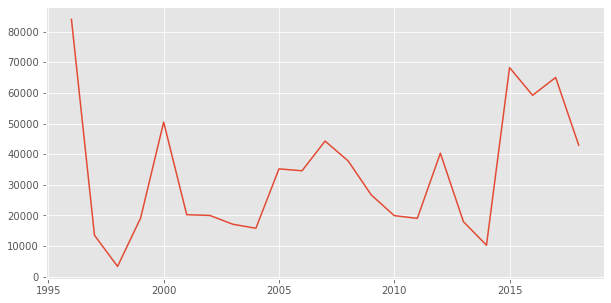

In [25]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#plot number of movies by year!
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(full_df2.movieId.groupby(full_df2["year"]).count())
plt.show()

In [26]:
def get_trend_movies(df_time_converted):
    """ method to return trend, input = df_with timestamp to date (year and month) """
    #get last date
    last = df_time_converted.sort_values(by=['year', "month"], ascending=False)
    last = last.reset_index(drop=True)
    year = last.iloc[0]['year']
    month = last.iloc[0]['month']
    print("year", year)
    print("month", month)

    #chose the last 5 movies (inverse index!!!)
    last_df = df_time_converted[ (df_time_converted['year'] == year) & (df_time_converted['month'] == month)]
    list_names_trend = last_df.groupby('title')['rating'].mean().sort_values().index[-5:]
    return list_names_trend

list_movies = get_trend_movies(full_df2)
list_movies

year 2018
month 9


Index(['Goodfellas (1990)', 'Shawshank Redemption, The (1994)',
       'In Bruges (2008)', 'Dark Knight, The (2008)',
       'Burn After Reading (2008)'],
      dtype='object', name='title')

In [27]:
#maybe just rated movies by friends??
friends = [ 474, 17]  
friends_df = full_df2[full_df2["userId"].isin(friends)]
get_trend_movies(friends_df)

year 2012
month 1


Index(['My Neighbor Totoro (Tonari no Totoro) (1988)', 'Taxi Driver (1976)',
       'Raging Bull (1980)'],
      dtype='object', name='title')

# Trick or threatie (Include Diversity)

In [28]:
# Never watched genre... select most rated movies!
# recommend the TRENDING movie based on DIVERSITY choices
#I need the SVD to made prediction to that user

user = 474 #target_user
df = full_df.copy()

def expand_colum(df, column_name, field='title'):
    """ transform a colum with stacked values in a crosstab colum """
    # remove duplicates
    
    df2 = df.drop_duplicates(subset=['title']).copy()

    # cast to list
    if df2[column_name].dtype == "int64":
        df2[column_name] = df2[column_name].tolist()
    else:
        df2[column_name] = df2[column_name].str.split('|').tolist()
    # explode into rows
    df = df2.explode(column_name)
    
    # let's make a crosstab
    df_column = pd.crosstab(df[field], df[column_name])
    df_column
    
    #return one df with columns by row (util to average statistics for example)
    #return a crosstab table
    return df, df_column

def get_genres(df, user):
    #return genres never watched     
    df_expanded, x2 = expand_colum(df, "genres") #expand genres columns to rows. x2 = is the crosstab! 
    dif_user = df_expanded.loc[df_expanded['userId'] != user]['genres'].unique()
    same_user = df_expanded.loc[df_expanded['userId'] == user]['genres'].unique()
    list_genres = list(set(dif_user)-set(same_user)) #as first set is a list of ALL other users i'assuming it is large array that a single user
    return list_genres

def get_movies(df, genres, user):
    #return list of movies never watched of that genres!
    df_expanded, x2 = expand_colum(df, "genres") #expand genres columns to rows. x2 = is the crosstab! 
    list_movies = df_expanded.loc[ (df_expanded['userId'] != user) & (df_expanded['genres'].isin(genres) ) ]
    list_movies.reset_index(inplace=True)
    return list_movies

genres = get_genres(full_df_genres, user)
movies_list = get_movies(full_df_genres, genres, user)


In [29]:
#show genres never watched!
genres

['(no genres listed)', 'Sci-Fi', 'Film-Noir', 'Western', 'Horror', 'Fantasy']

In [30]:
#show list of movies of that genres!
movies_list.head()

,index,movieId,title,genres,userId,rating,timestamp,tag
0,102973,913,"Maltese Falcon, The (1941)",Film-Noir,16,4.0,1377477016,statue
1,108049,930,Notorious (1946),Film-Noir,4,5.0,964538571,assassination
2,108310,968,Night of the Living Dead (1968),Horror,64,3.5,1161536420,zombies
3,119586,1212,"Third Man, The (1949)",Film-Noir,18,4.5,1455059742,ferris wheel
4,119784,1214,Alien (1979),Horror,1,4.0,964981855,aliens


In [31]:
#predict scores for that movies and sort_by that
predictions2 = []
for i in range(0,len(movies_list)):
    movie_id = movies_list.loc[i]["movieId"]
    pred = svd.predict(user, movie_id).est #chose only the value of prediction!
    predictions2.append(pred)

#create a new column with the predicitons
movies_list['pred'] = predictions2
movie_list = movies_list[['movieId', "title", "genres", "tag", "pred"]]

#order and return only 5 values!
movie_list.sort_values("pred", ascending=False)[0:5]

,movieId,title,genres,tag,pred
5,1258,"Shining, The (1980)",Horror,atmospheric,4.008160
0,913,"Maltese Falcon, The (1941)",Film-Noir,statue,4.006685
1,930,Notorious (1946),Film-Noir,assassination,3.994357
3,1212,"Third Man, The (1949)",Film-Noir,ferris wheel,3.953664
47,109487,Interstellar (2014),Sci-Fi,black hole,3.928913


## Random Chances!

In [32]:
# Random filme generator (excluded watched movies!) !
def get_random_movie(full_df_genres, target_user):
    #receive the dataframe, and a target_user
    import random
    genres = get_genres(full_df_genres, target_user)
    movies_list = get_movies(full_df_genres, genres, target_user)
    predictions2 = []
    for i in range(0,len(movies_list)):
        movie_id = movies_list.loc[i]["movieId"]
        pred = svd.predict(user, movie_id).est #chose only the value of prediction!
        predictions2.append(pred)

    #create a new column with the predicitons
    movies_list['pred'] = predictions2
    movie_list = movies_list[['movieId', "title", "genres", "tag", "pred"]]

    #order and return only 1 movie!
    return movie_list.loc[random.randint(0, len(movie_list))]

In [34]:
#Try your lucky :)
get_random_movie(full_df_genres, user)

movieId                      128360
title      The Hateful Eight (2015)
genres                      Western
tag                      characters
pred                          3.707
Name: 48, dtype: object